In [1]:

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, fbeta_score
from sklearn.metrics import classification_report

from xgboost import XGBClassifier

warnings.filterwarnings("ignore")

import required libraries for visualization

In [3]:
data=pd.read_csv("/kaggle/input/titanic/train.csv")
data_test=pd.read_csv("/kaggle/input/titanic/test.csv")
data_gender_submission=pd.read_csv("/kaggle/input/titanic/gender_submission.csv")


Import dataset

In [4]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Target variable is Survived with binary value 1 for survive 0 for didn't survive
Indicating classification problem
Passanger ID & Name won't be needed in this prediction
Continuous var : Fare & Age
Categorical var : Passangerclass, Sex, SiblingSpouse, ParentChild & Embarked
Ticket & Cabin will be analyse further to keep or drop

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Data out of 891 rows:
   Age          714 non-null    
   Cabin        204 non-null     
   Embarked     889 non-null     

In [6]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
PassengerId,891.0,446.000000,257.353842,1.00,223.5000,446.0000,668.5,891.0000
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
Pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
Age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292


In [7]:
cat_col=["Name","Sex","Ticket","Cabin","Embarked"]
pd.set_option("display.max_rows", 5)  # Show 5 rows
for col in cat_col:
    print(data[col].value_counts(1))
    print(f"unique: {data[col].nunique()}")
    print("-"*33)


Name
Braund, Mr. Owen Harris    0.001122
Boulos, Mr. Hanna          0.001122
                             ...   
Keane, Miss. Nora A        0.001122
Dooley, Mr. Patrick        0.001122
Name: proportion, Length: 891, dtype: float64
unique: 891
---------------------------------
Sex
male      0.647587
female    0.352413
Name: proportion, dtype: float64
unique: 2
---------------------------------
Ticket
347082      0.007856
CA. 2343    0.007856
              ...   
PC 17612    0.001122
370376      0.001122
Name: proportion, Length: 681, dtype: float64
unique: 681
---------------------------------
Cabin
B96 B98    0.019608
G6         0.019608
             ...   
E36        0.004902
C148       0.004902
Name: proportion, Length: 147, dtype: float64
unique: 147
---------------------------------
Embarked
S    0.724409
C    0.188976
Q    0.086614
Name: proportion, dtype: float64
unique: 3
---------------------------------


Since most value for Name, Ticket and Cabin are unique, it will be dropped.
This shows there are 65% male and 35% female passangers on board 
most passangers embarked on S port.

In [8]:
data_dupe = data.duplicated().sum()
data_null = data.isnull().sum()
print(f"duplicated: {data_dupe} \nis null:\n{data_null}")

duplicated: 0 
is null:
PassengerId      0
Survived         0
              ... 
Cabin          687
Embarked         2
Length: 12, dtype: int64


check for duplicate and null data

EXPLORATORY DATA ANALYSIS
_____________________________________________________________________________________
UNIVARIATE VISUALIZATION 

In [9]:
def histbox(data, feature, figsize=(7,7), kde=True, bins = None):
    f2, (axbox2,axhist2)= plt.subplots(
        2,
        sharex=True,
        gridspec_kw={"height_ratios":(0.25,0.75)},
        figsize=figsize,
    )
    sns.boxplot(data=data, x=feature, ax=axbox2, showmeans=True, color="blue")
    if bins == None:
       sns.histplot(data=data, x=feature, kde=kde, ax=axhist2, color='green') 
    else:
        sns.histplot(data=data, x=feature, kde=kde, ax=axhist2, bins=bins, color='green') 
    axhist2.axvline(data[feature].mean(), color="red", linestyle="--")
    axhist2.axvline(data[feature].median(), color="black", linestyle="-")
    

function for univariate analysis of continuous variable Fare & Age


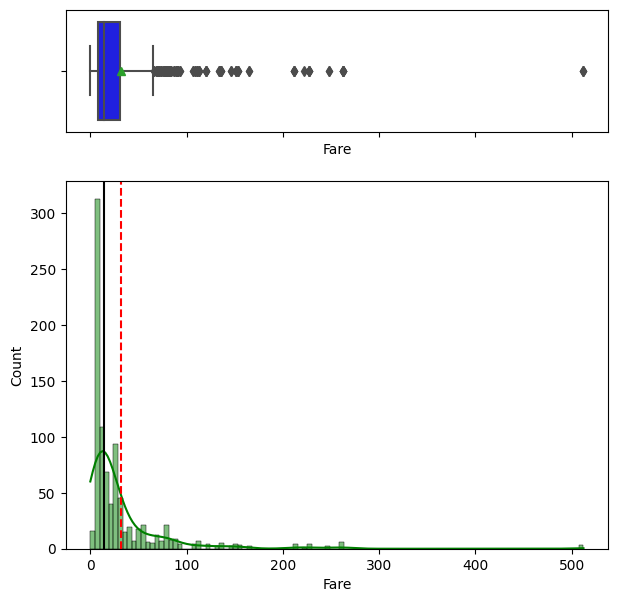

In [10]:
histbox(data, "Fare")

This indicates the majority pays lower fare. Also presence of an extreme outlier.

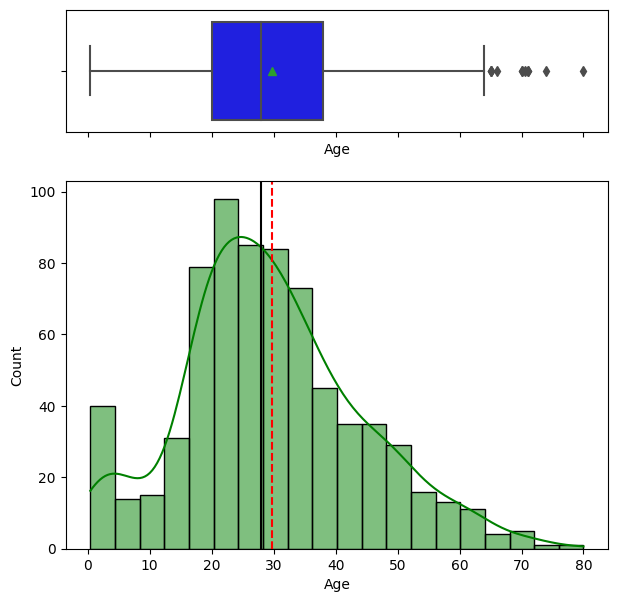

In [11]:
histbox(data, "Age")

Both numerical features isn't normally distributed, but sample size is large enough to proceed since Central Limit Theorem will apply.
Most on board passangers are Young adult and middle aged adult.

BIVARIATE ANALYSIS

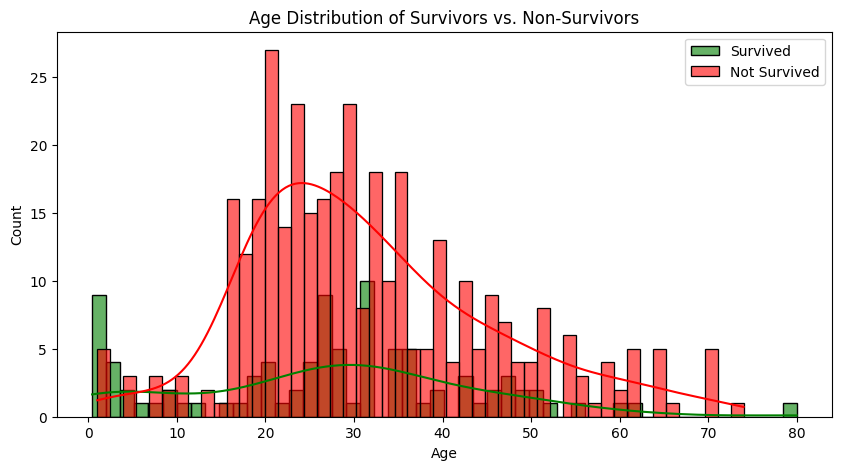

In [12]:
# Histogram for label and age
plt.figure(figsize=(10, 5))
sns.histplot(data[(data["Survived"] == 1)&(data["Sex"] == "male")]["Age"], bins=50, color="green", kde=True, label="Survived", alpha=0.6)
sns.histplot(data[(data["Survived"] == 0)&(data["Sex"] == "male")]["Age"], bins=50, color="red", kde=True, label="Not Survived", alpha=0.6)
plt.xlabel("Age")
plt.ylabel("Count")
plt.title("Age Distribution of Survivors vs. Non-Survivors")
plt.legend()
plt.show()

In [13]:
def stackedbar(data, predictor, target): #function for stacked barplot
    count= data[predictor].nunique()
    sorter= data[target].value_counts().index[-1]
    tab1=pd.crosstab(data[predictor], data[target], margins=True).sort_values(by=sorter, ascending=False)
    tab1_percent=(tab1.div(tab1["All"],axis=0)*100).round(1)
    print(tab1_percent)

Categorical predictor: sex, cabin, embarked, 

In [14]:
cat_list=["Sex","Embarked","Pclass","SibSp","Parch"]
for cat in cat_list:
    stackedbar(data, cat, "Survived")
    print("--"*33)

Survived     0     1    All
Sex                        
All       61.6  38.4  100.0
female    25.8  74.2  100.0
male      81.1  18.9  100.0
------------------------------------------------------------------
Survived     0     1    All
Embarked                   
All       61.8  38.2  100.0
S         66.3  33.7  100.0
C         44.6  55.4  100.0
Q         61.0  39.0  100.0
------------------------------------------------------------------
Survived     0     1    All
Pclass                     
All       61.6  38.4  100.0
1         37.0  63.0  100.0
3         75.8  24.2  100.0
2         52.7  47.3  100.0
------------------------------------------------------------------
Survived      0     1    All
SibSp                       
All        61.6  38.4  100.0
0          65.5  34.5  100.0
...         ...   ...    ...
5         100.0   0.0  100.0
8         100.0   0.0  100.0

[8 rows x 3 columns]
------------------------------------------------------------------
Survived      0     1    All
Pa

There are more male passangers proportions onboard and died, indicating over gender effect.
Embarking in C port also have higher rate of surviving
There is an inverse ordinal effect showing the lower the class value, the higher the survival rate
Sibling Spouse and Parent child shows a trend where the surviving rate peaks at certain point

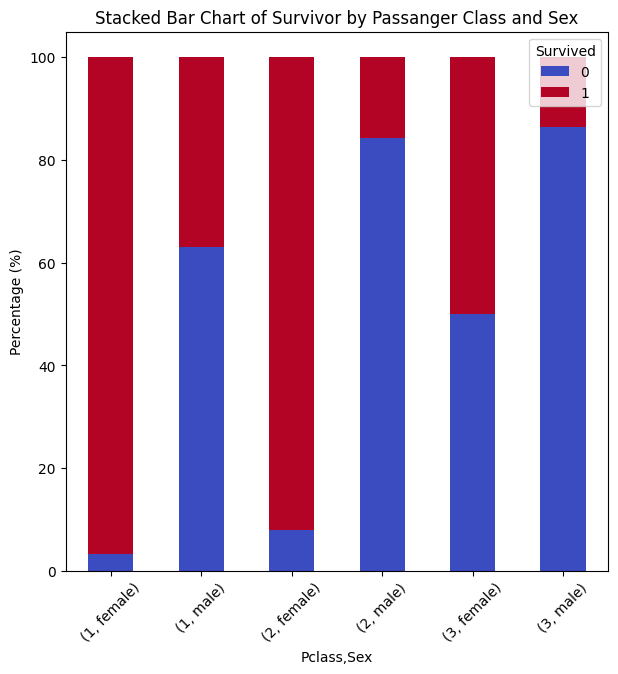

In [15]:
tab = pd.crosstab(index=[data["Pclass"], data["Sex"]], columns=data["Survived"], normalize="index") * 100
tab.plot(kind="bar", stacked=True, figsize=(7, 7), colormap="coolwarm")

plt.ylabel("Percentage (%)")
plt.title("Stacked Bar Chart of Survivor by Passanger Class and Sex")
plt.legend(title="Survived")
plt.xticks(rotation=45)
plt.show()

clas 2 and class 1 female are more likely to survive, while male start from class 3 are more likely to survive

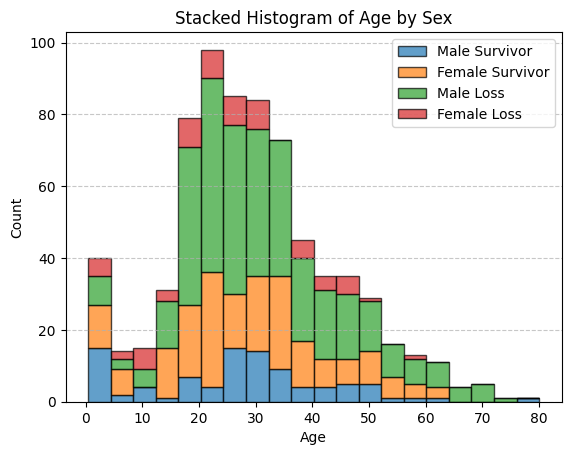

In [16]:
male_survived = data[(data['Sex']=='male')&(data['Survived']==1)]
female_survived = data[(data['Sex']=='female')&(data['Survived']==1)]
male_not_s = data[(data['Sex']=='male')&(data['Survived']==0)]
female_not_s = data[(data['Sex']=='female')&(data['Survived']==0)]


plt.hist([male_survived['Age'], female_survived['Age'], male_not_s['Age'], female_not_s['Age']],
         bins=20, stacked=True, label=['Male Survivor', 'Female Survivor','Male Loss','Female Loss'], alpha=0.7, edgecolor='black')

plt.xlabel("Age")
plt.ylabel("Count")
plt.title("Stacked Histogram of Age by Sex")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

Age more than 65 are unlikely to survive
the rest are distributed evenly

DATA PREPROCESSING

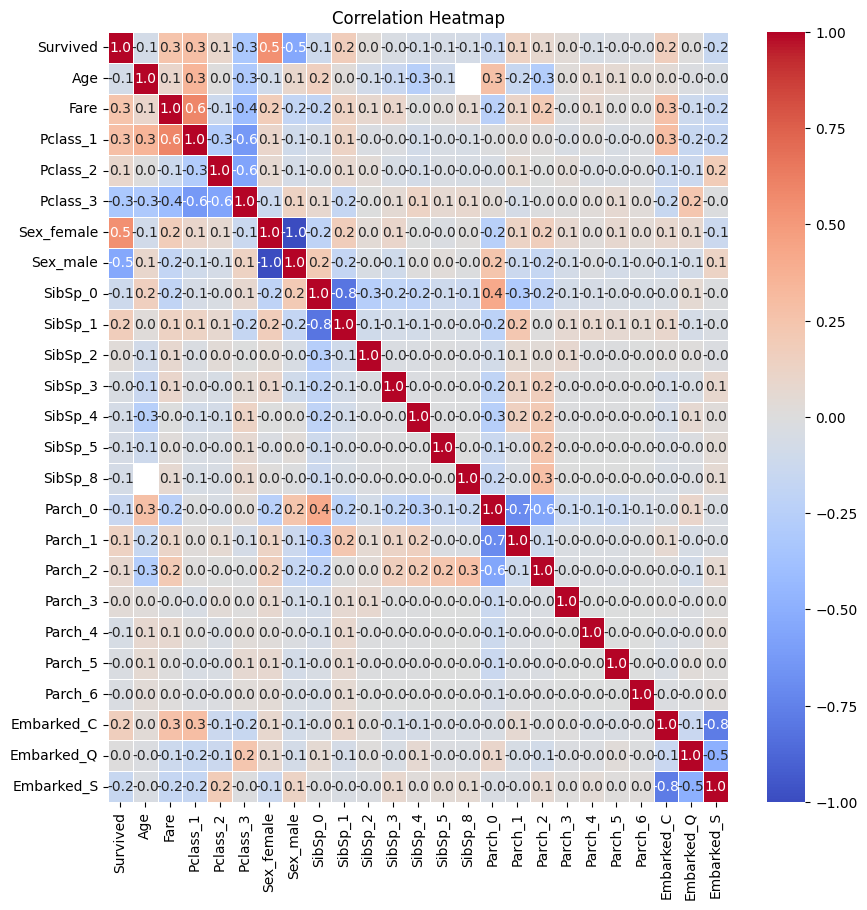

In [17]:
categorical_features = ['Pclass','Sex','SibSp','Parch','Embarked']
data_correlation=data
data_correlation=pd.get_dummies(data, columns=categorical_features, drop_first=False)
data_correlation.drop(columns=["PassengerId", 'Name', 'Cabin','Ticket'], axis=1, inplace=True)
corr_matrix = data_correlation.corr()

plt.figure(figsize=(10, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".1f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

TRAIN AND TEST DATA

In [18]:
data_gender_submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [19]:
data_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


MODEL BUILDING X & Y

In [20]:
x_train = data.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin', 'Survived'])
y_train = data['Survived']

#merge data test and data gender submission to get testing data without train test split
merged_test_initial =pd.merge(data_test, data_gender_submission, on='PassengerId')

# Drop age first since it has a lot of null values and not much correlation with Y
x_train_na=x_train.drop(columns=['Age'])
merged_test=merged_test_initial.drop(columns=['Age', 'PassengerId', 'Name', 'Ticket', 'Cabin'])
# one null add mean of fare (since it is not so important) first before split x and y 
merged_test["Fare"].fillna(merged_test["Fare"].mean(), inplace=True)
x_test_na = merged_test.drop(columns=['Survived'])
y_test = merged_test['Survived']

In [21]:
x_train_na =pd.get_dummies(x_train_na, columns=categorical_features, drop_first=True)
x_test_na =pd.get_dummies(x_test_na, columns=categorical_features, drop_first=True)
# dummy variables for categorical 

METRICS 

In [22]:
def model_performance_classification(model, predictors, targets):
    pred = model.predict(predictors)
    
    accuracy = accuracy_score(targets, pred)
    precision = precision_score(targets, pred, average='weighted')  
    recall = recall_score(targets, pred, average='weighted')  
    f2_score = fbeta_score(targets, pred, beta=2, average='weighted')  
    df_perf = pd.DataFrame({
        'Accuracy': [accuracy],
        'Precision': [precision],
        'Recall': [recall],
        'F2-Score': [f2_score]
    })
    
    return df_perf

Application of Decision Tree

In [23]:
dt_model = DecisionTreeClassifier(criterion='gini', max_depth=10, random_state=1)
dt_model.fit(x_train_na, y_train)

#plt.figure(figsize=(30,30))
#plot_tree(dt_model, feature_names=x_train_na.columns, class_names=['Survived','Dead'], filled=True)
#plt.show()

DecisionTreeClassifier(max_depth=10, random_state=1)

In [24]:
# Removing any column in test that isnt present in training
x_test_na = x_test_na[x_train_na.columns]

In [25]:
dtna_train = model_performance_classification(dt_model, x_train_na, y_train)
dtna_test = model_performance_classification(dt_model, x_test_na, y_test)

metrics_comparison = pd.DataFrame({
    "Metric": ["Accuracy", "Precision", "Recall", "F2-Score"],
    "Train Score": dtna_train.iloc[0].values,  # Extract values from DataFrame
    "Test Score": dtna_test.iloc[0].values
})

metrics_comparison

,Metric,Train Score,Test Score
0,Accuracy,0.884400,0.887560
1,Precision,0.894511,0.888038
2,Recall,0.884400,0.887560
3,F2-Score,0.880901,0.886368


trying random forest

In [26]:
rf_model = RandomForestClassifier(n_estimators=100,max_depth=8, random_state=1)
rf_model.fit(x_train_na, y_train)

RandomForestClassifier(max_depth=8, random_state=1)

In [27]:
# Perform cross-validation
cv_scores = cross_val_score(rf_model, x_train_na, y_train, cv=10, scoring='accuracy', n_jobs=-1)

# Display score
print("Mean CV Score:", cv_scores.mean())
print("Standard Deviation:", cv_scores.std())

Mean CV Score: 0.8114856429463171
Standard Deviation: 0.04054642277969844


Try to tune this model, since it has the best result

In [28]:
# Grid search for best parameter
param_grid = {
    'n_estimators': [100],  # 100 for stability
    'max_depth': [6],  # since the data set is small, split should be low
    'min_samples_split': [10,20],  # Minimum samples to split an internal node
    'min_samples_leaf': [5,10],
    'max_features': ['sqrt',12]
}

# Initialize RF model
rf_model_grid = RandomForestClassifier(random_state=1)

# Perform Grid Search with Cross-Validation
grid_search = GridSearchCV(rf_model_grid, param_grid, cv=10, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(x_train_na, y_train)

# Extract mean test scores from all parameter combinations
cv_scores = grid_search.cv_results_['mean_test_score']
cv_std = grid_search.cv_results_['std_test_score']

# Display best parameters and score
print("Best Parameters:", grid_search.best_params_)
print(f"Mean CV Score: {np.mean(cv_scores):.4f}")
print(f"Standard Deviation: {np.std(cv_std):.4f}")

Fitting 10 folds for each of 8 candidates, totalling 80 fits
Best Parameters: {'max_depth': 6, 'max_features': 12, 'min_samples_leaf': 5, 'min_samples_split': 20, 'n_estimators': 100}
Mean CV Score: 0.8048
Standard Deviation: 0.0069


In [29]:
# Grid search for best parameter
param_grid = {
    'n_estimators': [100],  # 100 for stability
    'max_depth': [8],  # since the data set is small, split should be low
    'max_features': [12],
    'bootstrap': [True, False],  # Bootstrap sampling for trees
    'class_weight': [None, 'balanced', 'balanced_subsample']
}

# Initialize RF model
rf_model_grid2 = RandomForestClassifier(random_state=1)

# Perform Grid Search with Cross-Validation
grid_search = GridSearchCV(rf_model_grid2, param_grid, cv=10, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(x_train_na, y_train)

# Extract mean test scores from all parameter combinations
cv_scores = grid_search.cv_results_['mean_test_score']
cv_std = grid_search.cv_results_['std_test_score']

# Display best parameters and score
print("Best Parameters:", grid_search.best_params_)
print(f"Mean CV Score: {np.mean(cv_scores):.4f}")
print(f"Standard Deviation: {np.std(cv_std):.4f}")

Fitting 10 folds for each of 6 candidates, totalling 60 fits
Best Parameters: {'bootstrap': True, 'class_weight': None, 'max_depth': 8, 'max_features': 12, 'n_estimators': 100}
Mean CV Score: 0.8081
Standard Deviation: 0.0045


In [30]:
# Fit model
rf_model_tuned = RandomForestClassifier(
    n_estimators=100,
    max_depth=8,
    max_features=12,
    bootstrap=True,
    class_weight=None,
    random_state=1,
    )
rf_model_tuned.fit(x_train_na, y_train)

RandomForestClassifier(max_depth=8, max_features=12, random_state=1)

This performs, better try submit

In [31]:
# match column for rf_model_tuned
trained_features = rf_model_tuned.feature_names_in_

x_test_na = x_test_na[trained_features]
x_test_na = x_test_na.reindex(columns=trained_features)
x_test_na.shape

(418, 18)

In [32]:
# including passanger ID back to dataset, there are 1 row dropped of missing value
model_predictions = rf_model_tuned.predict(x_test_na).flatten()

passenger_ids_fixed = merged_test_initial["PassengerId"].iloc[x_test_na.index]

# Create the final submission DataFrame
submission = pd.DataFrame({
    "PassengerId": passenger_ids_fixed,
    "Survived": model_predictions.astype(int)
})

# Save submission file
submission.to_csv("77.7%RFTuned.csv", index=False)
submission.shape

(418, 2)

77.5%

In [33]:
# Grid search for best parameter
param_grid = {
    'n_estimators': [100],  # 100 for stability
    'max_depth': [4],  # since the data set is small, split should be low
    'min_samples_split': [50],  # Minimum samples to split an internal node
    'min_samples_leaf': [20],
    'max_features': [12,18],
    'bootstrap':[True,False]
}

# Initialize RF model
rf_model_grid3 = RandomForestClassifier(random_state=1)

# Perform Grid Search with Cross-Validation
grid_search = GridSearchCV(rf_model_grid3, param_grid, cv=10, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(x_train_na, y_train)

# Extract mean test scores from all parameter combinations
cv_scores = grid_search.cv_results_['mean_test_score']
cv_std = grid_search.cv_results_['std_test_score']

# Display best parameters and score
print("Best Parameters:", grid_search.best_params_)
print(f"Mean CV Score: {np.mean(cv_scores):.4f}")
print(f"Standard Deviation: {np.std(cv_std):.4f}")

Fitting 10 folds for each of 4 candidates, totalling 40 fits
Best Parameters: {'bootstrap': True, 'max_depth': 4, 'max_features': 12, 'min_samples_leaf': 20, 'min_samples_split': 50, 'n_estimators': 100}
Mean CV Score: 0.7977
Standard Deviation: 0.0053


In [34]:
# Fit model
rf_model_tuned_2 = RandomForestClassifier(
    n_estimators=100,
    max_depth=4,
    max_features=12,
    min_samples_leaf=20,
    min_samples_split=50,
    bootstrap=True,
    random_state=1,
    )
rf_model_tuned_2.fit(x_train_na, y_train)

RandomForestClassifier(max_depth=4, max_features=12, min_samples_leaf=20,
                       min_samples_split=50, random_state=1)

In [35]:
# match column for rf_model_tuned
trained_features = rf_model_tuned_2.feature_names_in_

x_test_na = x_test_na[trained_features]
x_test_na = x_test_na.reindex(columns=trained_features)
x_test_na.shape

(418, 18)

In [36]:
# including passanger ID back to dataset, there are 1 row dropped of missing value
model_predictions = rf_model_tuned_2.predict(x_test_na).flatten()

passenger_ids_fixed = merged_test_initial["PassengerId"].iloc[x_test_na.index]

# Create the final submission DataFrame
submission = pd.DataFrame({
    "PassengerId": passenger_ids_fixed,
    "Survived": model_predictions.astype(int)
})

# Save submission file
submission.to_csv("77.7%RFTuned4depth.csv", index=False)
submission.shape

(418, 2)

77.0%

In [37]:
# Fit model
rf_model_tuned_3 = RandomForestClassifier(
    n_estimators=100,
    max_depth=8,
    bootstrap=True,
    random_state=1,
    )
rf_model_tuned_3.fit(x_train_na, y_train)

RandomForestClassifier(max_depth=8, random_state=1)

In [38]:
# match column for rf_model_tuned
trained_features = rf_model_tuned_3.feature_names_in_

x_test_na = x_test_na[trained_features]
x_test_na = x_test_na.reindex(columns=trained_features)
x_test_na.shape

(418, 18)

In [39]:
# including passanger ID back to dataset, there are 1 row dropped of missing value
model_predictions = rf_model_tuned_3.predict(x_test_na).flatten()

passenger_ids_fixed = merged_test_initial["PassengerId"].iloc[x_test_na.index]

# Create the final submission DataFrame
submission = pd.DataFrame({
    "PassengerId": passenger_ids_fixed,
    "Survived": model_predictions.astype(int)
})

# Save submission file
submission.to_csv("77.7%RFTunedBootstrap.csv", index=False)
submission.shape

(418, 2)

____________________________________________________________________________________

In [40]:
rfna_train = model_performance_classification(rf_model, x_train_na, y_train)
rfna_test = model_performance_classification(rf_model, x_test_na, y_test)

metrics_comparison = pd.DataFrame({
    "Metric": ["Accuracy", "Precision", "Recall", "F2-Score"],
    "Train Score": rfna_train.iloc[0].values,  # Extract values from DataFrame
    "Test Score": rfna_test.iloc[0].values
})

metrics_comparison

,Metric,Train Score,Test Score
0,Accuracy,0.876543,0.887560
1,Precision,0.885589,0.888038
2,Recall,0.876543,0.887560
3,F2-Score,0.873033,0.886368


Decision tree with custom pruning

In [41]:
dtna_prune_model= DecisionTreeClassifier(criterion='gini',max_depth=10,random_state=1)
dtna_prune_path = dtna_prune_model.cost_complexity_pruning_path(x_train_na, y_train)
ccp_alphas = dtna_prune_path.ccp_alphas  # List of possible alpha values

results = []

for alpha in ccp_alphas:
    dt = DecisionTreeClassifier(random_state=1, ccp_alpha=alpha)
    dt.fit(x_train_na, y_train)
    
    train_acc = dt.score(x_train_na, y_train)
    test_acc = dt.score(x_test_na, y_test)
    
    results.append({"ccp_alpha": alpha, "Train Accuracy": train_acc, "Test Accuracy": test_acc})

# Convert to DataFrame
pruning_results = pd.DataFrame(results)
pruning_results

,ccp_alpha,Train Accuracy,Test Accuracy
0,0.000000,0.924804,0.861244
1,0.000026,0.924804,0.861244
...,...,...,...
63,0.034975,0.786756,1.000000
64,0.139648,0.616162,0.636364


In [42]:
dtna_pruned_tree = DecisionTreeClassifier(random_state=1, ccp_alpha=0.0012)
dtna_pruned_tree.fit(x_train_na, y_train)

DecisionTreeClassifier(ccp_alpha=0.0012, random_state=1)

In [43]:
dtna_pruned_tree_train = model_performance_classification(dtna_pruned_tree, x_train_na, y_train)
dtna_pruned_tree_test = model_performance_classification(dtna_pruned_tree, x_test_na, y_test)

metrics_comparison = pd.DataFrame({
    "Metric": ["Accuracy", "Precision", "Recall", "F2-Score"],
    "Train Score": dtna_pruned_tree_train.iloc[0].values,  # Extract values from DataFrame
    "Test Score": dtna_pruned_tree_test.iloc[0].values
})

metrics_comparison

,Metric,Train Score,Test Score
0,Accuracy,0.893378,0.882775
1,Precision,0.893438,0.883351
2,Recall,0.893378,0.882775
3,F2-Score,0.892745,0.882860


In [44]:
# comparing all algorithms accuracy for test and train
algorithm_list = ['dtna_train','dtna_test','rfna_train','rfna_test','dtna_pruned_tree_train','dtna_pruned_tree_test']
all_metrics_comparison = pd.DataFrame({
    "Metric": ["Accuracy", "Precision", "Recall", "F2-Score"],
    "Decision Tree Train Score": dtna_train.iloc[0].values,  
    "Decision Tree Test Score": dtna_test.iloc[0].values,
    "Random Forest Train Score": rfna_train.iloc[0].values,  
    "Random Forest Test Score": rfna_test.iloc[0].values,
    "Pruned Tree Train Score": dtna_pruned_tree_train.iloc[0].values,  
    "Pruned Tree Test Score": dtna_pruned_tree_test.iloc[0].values
})

all_metrics_comparison.set_index("Metric", inplace=True)
all_metrics_comparison.T

Metric,Accuracy,Precision,Recall,F2-Score
Decision Tree Train Score,0.884400,0.894511,0.884400,0.880901
Decision Tree Test Score,0.887560,0.888038,0.887560,0.886368
...,...,...,...,...
Pruned Tree Train Score,0.893378,0.893438,0.893378,0.892745
Pruned Tree Test Score,0.882775,0.883351,0.882775,0.882860


ADDING PASSANGER ID BACK FOR SUBMISSION REQUIREMENT

In [45]:
# including passanger ID back to dataset, there are 1 row dropped of missing value
model_predictions = dtna_pruned_tree.predict(x_test_na).flatten()

passenger_ids_fixed = merged_test_initial["PassengerId"].iloc[x_test_na.index]

# Create the final submission DataFrame
submission = pd.DataFrame({
    "PassengerId": passenger_ids_fixed,
    "Survived": model_predictions.astype(int)
})

# Save submission file
submission.to_csv("submissionDTP.csv", index=False)
submission.shape

(418, 2)

THIS ATTEMPT GET 74% OF ACCURACY

In [46]:
# including passanger ID back to dataset, there are 1 row dropped of missing value
model_predictions = rf_model.predict(x_test_na).flatten()

passenger_ids_fixed = merged_test_initial["PassengerId"].iloc[x_test_na.index]

# Create the final submission DataFrame
submission = pd.DataFrame({
    "PassengerId": passenger_ids_fixed,
    "Survived": model_predictions.astype(int)
})

# Save submission file
submission.to_csv("submissionRF.csv", index=False)
submission.shape

(418, 2)

THIS ATTEMPT GET 77.7% OF ACCURACY

In [47]:
# Try random forest attempt with class weight adjustment
rf_model_weight = RandomForestClassifier(
    n_estimators=100,
    max_depth=8,
    random_state=1,
    class_weight={0:6.2,1:3.8})
rf_model_weight.fit(x_train_na, y_train)

RandomForestClassifier(class_weight={0: 6.2, 1: 3.8}, max_depth=8,
                       random_state=1)

In [48]:
# including passanger ID back to dataset, there are 1 row dropped of missing value
model_predictions = rf_model_weight.predict(x_test_na).flatten()

passenger_ids_fixed = merged_test_initial["PassengerId"].iloc[x_test_na.index]

# Create the final submission DataFrame
submission = pd.DataFrame({
    "PassengerId": passenger_ids_fixed,
    "Survived": model_predictions.astype(int)
})

# Save submission file
submission.to_csv("submissionRF_weighted.csv", index=False)
submission.shape

(418, 2)

THIS ATTEMPT GET 77.5% ACCURACY

______________________________________________________________________
DATA PREPROCESSING AGAIN, NOW WITH AGE AND BINNING

In [49]:
# binning age
age_bins = [-np.inf, 15, np.inf]  # -inf ensures all ages <15 go into the first bin
age_labels = ["<15", "15>="]

# Bin the Age column (including NaN values)
train_data_bin=data.copy()
test_data_bin=merged_test_initial.copy()
train_data_bin["AgeGroup"] = pd.cut(train_data_bin["Age"].fillna(15), bins=age_bins, labels=age_labels)
test_data_bin["AgeGroup"] = pd.cut(test_data_bin["Age"].fillna(15), bins=age_bins, labels=age_labels)

# Check the bin counts
test_data_bin.shape

(418, 13)

In [50]:
test_data_bin.isnull().sum()

PassengerId    0
Pclass         0
              ..
Survived       0
AgeGroup       0
Length: 13, dtype: int64

In [51]:
# null value preprocessing
train_data_bin["Embarked"].fillna(train_data_bin["Embarked"].mode()[0], inplace=True)
test_data_bin["Fare"].fillna(merged_test["Fare"].mode()[0], inplace=True)

# Check the null value count
test_data_bin.isnull().sum()

PassengerId    0
Pclass         0
              ..
Survived       0
AgeGroup       0
Length: 13, dtype: int64

In [52]:
#Sibling Spouse & Parch Binning
#Add new Family_bin changing sibling spouse and parch, since they have same threshold
train_data_bin["FamilyMax"] = np.where((train_data_bin["SibSp"]<4 )|( train_data_bin["Parch"]<4), "<4", "4>=")
test_data_bin["FamilyMax"] = np.where((test_data_bin["SibSp"]<4 )|( test_data_bin["Parch"]<4), "<4", "4>=")

# Check the bin counts
test_data_bin.shape

(418, 14)

In [53]:
# dummy variable
categorical_features=['Pclass','Sex','Embarked','AgeGroup','FamilyMax']
train_data_bin=pd.get_dummies(train_data_bin, columns=categorical_features, drop_first=True)
test_data_bin=pd.get_dummies(test_data_bin, columns=categorical_features, drop_first=True)

In [54]:
# Drop age and cabin 'PassengerId','Name','Ticket', Parch, SibSp
train_data_bin=train_data_bin.drop(columns=['Age','Cabin','PassengerId','Name','Ticket','Parch','SibSp'])
test_data_bin=test_data_bin.drop(columns=['Age','Cabin','PassengerId','Name','Ticket','Parch','SibSp'])

MODEL BUILDING

In [55]:
x_train_bin=train_data_bin.drop(columns=['Survived'])
y_train_bin=train_data_bin['Survived']
x_test_bin=test_data_bin.drop(columns=['Survived'])
y_test_bin=test_data_bin['Survived']

In [56]:
# Initialize a list to store results
results = []

# Loop through max_depth values from 5 to 15
for depth in range(5, 16):
    # Train RandomForest with current max_depth
    rf_bin = RandomForestClassifier(
        n_estimators=100, 
        max_depth=depth, 
        random_state=1,
        class_weight={0: 6.2, 1: 3.8}
    )
    rf_bin.fit(x_train_bin, y_train_bin)
    
    # Evaluate on train & test sets
    train_metrics = model_performance_classification(rf_bin, x_train_bin, y_train_bin)
    test_metrics = model_performance_classification(rf_bin, x_test_bin, y_test_bin)
    
    # Store results
    results.append({
        "max_depth": depth,
        "Train Accuracy": train_metrics.iloc[0, 0],  # Assuming Accuracy is the first row
        "Test Accuracy": test_metrics.iloc[0, 0]
    })

# Convert results into a DataFrame
results_df = pd.DataFrame(results)

results_df

,max_depth,Train Accuracy,Test Accuracy
0,5,0.828283,0.858852
1,6,0.848485,0.870813
...,...,...,...
9,14,0.924804,0.858852
10,15,0.924804,0.858852


In [57]:
# Cross validation to check assumption for best depth
best_rf_bin = RandomForestClassifier(
        n_estimators=100, 
        max_depth=7, 
        random_state=1,
        class_weight={0: 6.2, 1: 3.8}
    )
cv_scores = cross_val_score(best_rf_bin, x_train_bin, y_train_bin, cv=10)

print("Cross-validation accuracy:", cv_scores.mean())

Cross-validation accuracy: 0.8271410736579276


In [58]:
best_rf_bin.fit(x_train_bin,y_train_bin)

RandomForestClassifier(class_weight={0: 6.2, 1: 3.8}, max_depth=7,
                       random_state=1)

Export Prediction as csv

In [59]:
# including passanger ID back to dataset, there are 1 row dropped of missing value
model_predictions = best_rf_bin.predict(x_test_bin).flatten()

passenger_ids_fixed = merged_test_initial["PassengerId"].iloc[x_test_na.index]

# Create the final submission DataFrame
submission = pd.DataFrame({
    "PassengerId": merged_test_initial["PassengerId"],
    "Survived": model_predictions.astype(int)
})

# Save submission file
submission.to_csv("submissionRFbin2.csv", index=False)
submission.shape

(418, 2)

The model above has an accuracy of 74.4% , with class_weight={0: 6.2, 1: 3.8}, it regains at 77.2% still lower than random forest

__________________________________________________________________________

In [60]:
# Trying to boost Accuracy using XGBoost (without binning)

param_grid = {
    'n_estimators': [100],
    'max_depth': [4,5,6,7,8], 
    'learning_rate': [0.05,0.1],
    'subsample': [0.8],
    'colsample_bytree': [0.5,0.8]
}
xgb_na = XGBClassifier(random_state=1)

# Grid search with 5-fold cross-validation
xgb_na_grid_search = GridSearchCV(xgb_na, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

# Fit GridSearchCV (this finds the best hyperparameters)
xgb_na_grid_search.fit(x_train_na, y_train)

# Use the best model found by GridSearchCV
best_xgb_na = xgb_na_grid_search.best_estimator_

# Make predictions using the best model
xgb_na_preds = best_xgb_na.predict(x_test_na)

# Print the best parameters and best accuracy
print("Best parameters:", xgb_na_grid_search.best_params_)
print("Best cross-validation accuracy:", xgb_na_grid_search.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.8}
Best cross-validation accuracy: 0.8114744837110036


In [61]:
# Trying to boost Accuracy using XGBoost (with binning)
xgb_bin = XGBClassifier(random_state=1)

# Grid search with 5-fold cross-validation
xgb_bin_grid_search = GridSearchCV(xgb_bin, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

xgb_bin_grid_search.fit(x_train_bin, y_train_bin)

# Use the best model found by GridSearchCV
best_xgb_bin = xgb_bin_grid_search.best_estimator_

# Make predictions using the best model
xgb_bin_preds = best_xgb_bin.predict(x_test_bin)

# Print the best parameters and best accuracy
print("Best parameters:", xgb_bin_grid_search.best_params_)
print("Best cross-validation accuracy:", xgb_bin_grid_search.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters: {'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.8}
Best cross-validation accuracy: 0.8271797125102001


Binning gives better accuracy overall

In [62]:
# comparing XGBoost with'without bin accuracy for test and train
XG_metrics_comparison = pd.DataFrame({
    "Metric": ["Accuracy", "Precision", "Recall", "F2-Score"],
    "XGBoost W/ Age Train Score": model_performance_classification(best_xgb_na, x_train_na, y_train).iloc[0].values,  
    "XGBoost W/ Age Test Score": model_performance_classification(best_xgb_na, x_test_na, y_test).iloc[0].values,
    "XGBoost Binning Train Score": model_performance_classification(best_xgb_bin, x_train_bin, y_train_bin).iloc[0].values,  
    "XGBoost Binning Test Score": model_performance_classification(best_xgb_bin, x_test_bin, y_test_bin).iloc[0].values
})

XG_metrics_comparison.set_index("Metric", inplace=True)
XG_metrics_comparison.T

Metric,Accuracy,Precision,Recall,F2-Score
XGBoost W/ Age Train Score,0.879910,0.879798,0.879910,0.879163
XGBoost W/ Age Test Score,0.892344,0.892247,0.892344,0.891524
XGBoost Binning Train Score,0.887767,0.888642,0.887767,0.886712
XGBoost Binning Test Score,0.894737,0.894161,0.894737,0.894396


Binning have better score

In [63]:
# including passanger ID back to dataset XG BOOST w/ Binning
model_predictions = best_xgb_bin.predict(x_test_bin).flatten()

passenger_ids_fixed = merged_test_initial["PassengerId"].iloc[x_test_na.index]

# Create the final submission DataFrame
submission = pd.DataFrame({
    "PassengerId": merged_test_initial["PassengerId"],
    "Survived": model_predictions.astype(int)
})

# Save submission file
submission.to_csv("submissionXGbin.csv", index=False)
submission.shape

(418, 2)

THIS ATTEMPT GETS 77.0% ACCURACY

In [64]:
# including passanger ID back to dataset
model_predictions = best_xgb_na.predict(x_test_na).flatten()

passenger_ids_fixed = merged_test_initial["PassengerId"].iloc[x_test_na.index]

# Create the final submission DataFrame
submission = pd.DataFrame({
    "PassengerId": merged_test_initial["PassengerId"],
    "Survived": model_predictions.astype(int)
})

# Save submission file
submission.to_csv("submissionXGna.csv", index=False)
submission.shape

(418, 2)

THIS ATTEMPT GETS 76.3% ACCURACY

In [65]:
# last try , Chat Gpt recommendation
try_xgb = XGBClassifier(
    n_estimators=500,        # More boosting rounds
    learning_rate=0.03,      # Slower learning rate for better optimization
    max_depth=6,             # Reduce depth to prevent overfitting
    subsample=0.8,           # Use 80% of training data per tree
    colsample_bytree=0.8,    # Use 80% of features per tree
    reg_lambda=2,            # Increase L2 regularization
    reg_alpha=1,             # Add some L1 regularization
    random_state=1
)
try_xgb.fit(x_train_bin, y_train_bin)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, random_state=1, ...)

In [66]:
# comparing XGBoost with'without bin accuracy for test and train
try_XG_metrics = pd.DataFrame({
    "Metric": ["Accuracy", "Precision", "Recall", "F2-Score"],
    "XGBoost W/ Age Train Score": model_performance_classification(try_xgb, x_train_bin, y_train_bin).iloc[0].values,  
    "XGBoost W/ Age Test Score": model_performance_classification(try_xgb, x_test_bin, y_test_bin).iloc[0].values
})

try_XG_metrics.set_index("Metric", inplace=True)
try_XG_metrics.T

Metric,Accuracy,Precision,Recall,F2-Score
XGBoost W/ Age Train Score,0.878788,0.879585,0.878788,0.877606
XGBoost W/ Age Test Score,0.906699,0.906319,0.906699,0.906332


In [67]:
# including passanger ID back to dataset
model_predictions = try_xgb.predict(x_test_bin).flatten()

passenger_ids_fixed = merged_test_initial["PassengerId"].iloc[x_test_na.index]

# Create the final submission DataFrame
submission = pd.DataFrame({
    "PassengerId": merged_test_initial["PassengerId"],
    "Survived": model_predictions.astype(int)
})

# Save submission file
submission.to_csv("submissionXGgpt.csv", index=False)
submission.shape

(418, 2)

THIS ATTEMPT GETS 77.2% ACCURACY

______________________________________________________________________________
Attempt to Split data into train and test first

In [68]:
#splitting the data
x_train_s, x_test_s, y_train_s, y_test_s = train_test_split(data.drop(columns=['Survived']), data['Survived'], 
                                                    test_size=0.2,  # 20% for testing
                                                    random_state=1,  # Ensures reproducibility
                                                    stratify=data['Survived'])  # Ensures class balance

print(f"Training set size: {x_train_s.shape}")
print(f"Test set size: {x_test_s.shape}")

Training set size: (712, 11)
Test set size: (179, 11)


In [69]:
# fill Embarked null value with mode
x_train_s["Embarked"].fillna(x_train_s["Embarked"].mode()[0], inplace=True)

In [70]:
# Also the submission final test
# Since 1 fare value is missing, add with mode 
submission_test=merged_test_initial
submission_test["Fare"].fillna(submission_test["Fare"].mode()[0], inplace=True)

In [71]:
# add dummy variable for categorical
categorical_var = ['Sex','SibSp','Parch','Embarked']

x_train_s=pd.get_dummies(x_train_s, columns=categorical_var, drop_first=True)
x_test_s=pd.get_dummies(x_test_s, columns=categorical_var, drop_first=True)
submission_test=pd.get_dummies(submission_test, columns=categorical_var, drop_first=True)

In [72]:
#drop redundant columns, Age is dropped on this trial
drop_column = ['Name','PassengerId','Ticket','Cabin','Age']
x_train_s=x_train_s.drop(columns=drop_column)
x_test_s=x_test_s.drop(columns=drop_column)
submission_test=submission_test.drop(columns=drop_column)

In [73]:
# Ensure Columns are the same and fill it with mode
missing_cols = set(x_train_s.columns) - set(x_test_s.columns)

# Fill missing columns in test with mode from train
for col in missing_cols:
    x_test_s[col] = x_train_s[col].mode()[0]  # Fill with train mode

# Reorder test columns to match train
x_test_s = x_test_s[x_train_s.columns]

In [74]:
# Fitting best model
rf_model_s = RandomForestClassifier(n_estimators=100,max_depth=10, min_samples_split=50, random_state=1)
rf_model_s.fit(x_train_s, y_train_s)

RandomForestClassifier(max_depth=10, min_samples_split=50, random_state=1)

In [75]:
# Train & Test Score
rf_train_s = model_performance_classification(rf_model_s, x_train_s, y_train_s)
rf_test_s = model_performance_classification(rf_model_s, x_test_s, y_test_s)

metrics_comparison = pd.DataFrame({
    "Metric": ["Accuracy", "Precision", "Recall", "F2-Score"],
    "Train Score": rf_train_s.iloc[0].values,  # Extract values from DataFrame
    "Test Score": rf_test_s.iloc[0].values
})

metrics_comparison

,Metric,Train Score,Test Score
0,Accuracy,0.820225,0.843575
1,Precision,0.824148,0.843899
2,Recall,0.820225,0.843575
3,F2-Score,0.816057,0.841838


In [76]:
# Grid search for best parameter
param_grid = {
    'n_estimators': [100],  # 100 for stability
    'max_depth': [4,5,6,7,8],  # since the data set is small, split should be low
    'min_samples_split': [10,20,50,100]  # Minimum samples to split an internal node
}

# Initialize RF model
rf_model_s = RandomForestClassifier(random_state=1)

# Perform Grid Search with Cross-Validation
grid_search = GridSearchCV(rf_model_s, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(x_train_s, y_train_s)

# Display best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters: {'max_depth': 5, 'min_samples_split': 50, 'n_estimators': 100}
Best Cross-Validation Score: 0.7865261499064314


In [77]:
# use test data to validate the grid search best result
# Get the best model
best_rf = grid_search.best_estimator_

# Retrain on full train set
best_rf.fit(x_train_s, y_train_s)

# Evaluate on the test set
y_pred = best_rf.predict(x_test_s)

# Check performance
print(classification_report(y_test_s, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.95      0.89       110
           1       0.89      0.70      0.78        69

    accuracy                           0.85       179
   macro avg       0.86      0.82      0.83       179
weighted avg       0.85      0.85      0.84       179



In [78]:
# match submission_test columns to best rf model
trained_features = best_rf.feature_names_in_

submission_test = submission_test[trained_features]
submission_test = submission_test.reindex(columns=trained_features)
submission_test.shape

(418, 17)

In [79]:
# use submission_test data to compare result with titanic's web result
submission_test_y =merged_test_initial['Survived']
y_pred = best_rf.predict(submission_test)
print(classification_report(submission_test_y, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.96      0.91       266
           1       0.91      0.74      0.81       152

    accuracy                           0.88       418
   macro avg       0.89      0.85      0.86       418
weighted avg       0.88      0.88      0.87       418



It gets accuracy of 88% here

In [80]:
# Export prediction for submission
# including passanger ID back to dataset and fill missing value with mode
model_predictions = best_rf.predict(submission_test).flatten()

passenger_ids_fixed = merged_test_initial["PassengerId"].iloc[x_test_na.index]

# Create the final submission DataFrame
submission = pd.DataFrame({
    "PassengerId": passenger_ids_fixed,
    "Survived": model_predictions.astype(int)
})

# Save submission file
submission.to_csv("RFWithSplit.csv", index=False)
submission.shape

(418, 2)

THIS ATTEMPTS GET 76.315% , it differs slightly from cross validation score.